<a href="https://colab.research.google.com/github/cooperhammond/nn-interpretability/blob/master/Visualizing_Polytopes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

iris = datasets.load_iris()
X = iris.data#[:, 2:4]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from sklearn.preprocessing import normalize

def gen_model(bias_initializer = 'random_uniform'):
    model = Sequential()
    model.add(InputLayer(input_shape=(4,)))
    model.add(Dense(40, activation='relu', bias_initializer=bias_initializer))
    model.add(Dense(20, activation='relu', bias_initializer=bias_initializer))
    model.add(Dense(3, activation='softmax', bias_initializer=bias_initializer))

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
from sympy import Eq, Matrix, symbols, solveset

def gen_layer_polytopes(model, layer_idx, prev_activations=list(symbols('x1 x2'))):
    activations = []
    layer = model.layers[i]
    layer_weights = layer.get_weights()

    for neuron_idx in range(0, layer_weights[0].shape[-1]):
        b = layer_weights[1][neuron_idx]
            
        eq = (Matrix([current_weights]) * Matrix(prev_activations) + Matrix([b]))[0]
        
        activations.append(eq)

    return activations

m = gen_model()
gen_layer_polytopes(m, i, list(symbols('x1 x2')) + [1.4, 0.2])

Model: "sequential"


In [ ]:
from sympy import Eq, Matrix, symbols, solveset

def generate_polytopes(model, i, prev_activations=list(symbols('x1 x2')) +  [1.4, 0.2], total_activations=[], first_run=True):

    if first_run:
        total_activations = []

    activations = []
    layer = model.layers[i]
    layer_weights = layer.get_weights()
    
    for neuron_idx in range(0, layer_weights[0].shape[-1]):
        current_weights = [weights[neuron_idx] for weights in layer_weights[0]]
        b = layer_weights[1][neuron_idx]
            
        eq = (Matrix([current_weights]) * Matrix(prev_activations) + Matrix([b]))[0]
        
        activations.append(eq)
        total_activations.append(eq)
        
    if i+1 < len(model.layers):
        return generate_polytopes(model, i+1, prev_activations=activations, total_activations=total_activations, first_run=False)
    else:
        return total_activations

In [ ]:
def graph_polytope_boundaries(polytope_bounds, epoch=0):
    from sympy.core.mul import Mul
    import matplotlib

    fig = plt.figure(epoch)
    fig.clf()
    ax = fig.add_subplot()

    l = 1.2
    ax.set_xlim([-l, l])
    ax.set_ylim([-l, l])
    
    for line in polytope_bounds:                
            intercept = 0
            slope = 0
            if type(line.args[1]) == Mul:
                intercept = line.args[0]
                slope = line.args[1].args[0]
            else:
                slope = line.args[0] 
        
            x = np.linspace(-l, l, int(l * 15))
            ax.plot(x, slope * x + intercept, '-', color="black", linewidth=0.5)

            plt.savefig(f'./img/img_{epoch}.png', 
                transparent = False,  
                facecolor = 'white'
               )

            fig.show()

In [ ]:
class PolytopeVisualizationCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % 1 == 0:
          polytope_bounds = [solveset(eq, symbols("x2")).args[0] for eq in generate_polytopes(self.model, 0)]
          graph_polytope_boundaries(polytope_bounds, epoch=epoch)

rm: cannot remove './img': No such file or directory
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                200       
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 5s 7ms/step - loss: 1.3342 - accuracy: 0.3333
Epoch 2/30
4/4 [==============================] - 0s 4ms/step - loss: 1.1928 - accuracy: 0.3333
Epoch 3/30
4/4 [==============================] - 0s 5ms/step - loss: 1.0

<ipython-input-6-8251dc046827>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(epoch)


Epoch 21/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6082 - accuracy: 0.8148
Epoch 22/30
4/4 [==============================] - 0s 4ms/step - loss: 0.5897 - accuracy: 0.8593
Epoch 23/30
4/4 [==============================] - 0s 5ms/step - loss: 0.5729 - accuracy: 0.8519
Epoch 24/30
4/4 [==============================] - 0s 4ms/step - loss: 0.5554 - accuracy: 0.8889
Epoch 25/30
4/4 [==============================] - 0s 4ms/step - loss: 0.5380 - accuracy: 0.9037
Epoch 26/30
4/4 [==============================] - 0s 5ms/step - loss: 0.5233 - accuracy: 0.9481
Epoch 27/30
4/4 [==============================] - 0s 5ms/step - loss: 0.5071 - accuracy: 0.9333
Epoch 28/30
4/4 [==============================] - 0s 4ms/step - loss: 0.4923 - accuracy: 0.9037
Epoch 29/30
4/4 [==============================] - 0s 5ms/step - loss: 0.4785 - accuracy: 0.9037
Epoch 30/30
4/4 [==============================] - 0s 5ms/step - loss: 0.4655 - accuracy: 0.9407


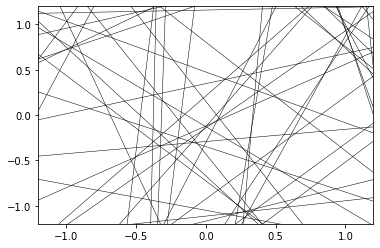

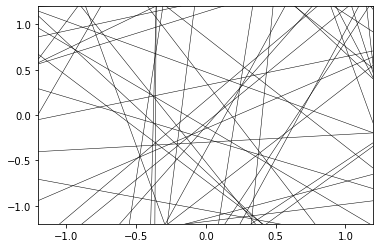

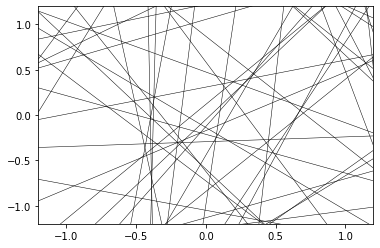

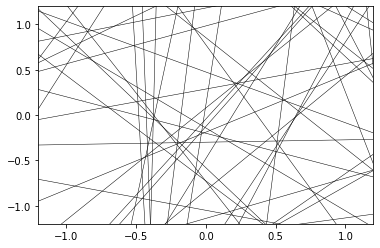

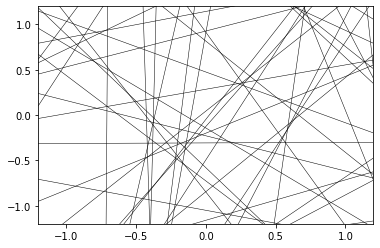

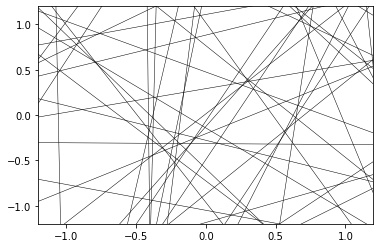

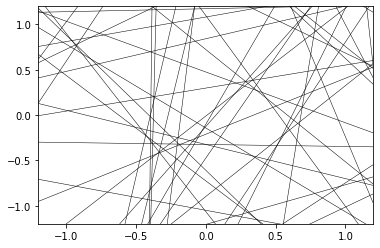

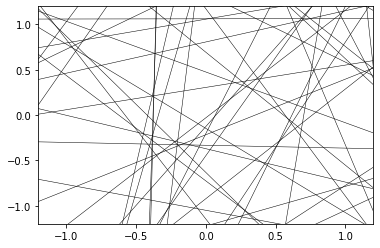

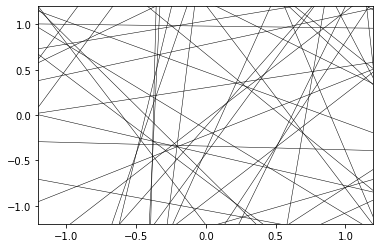

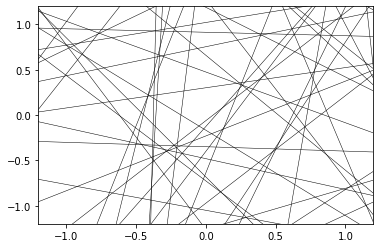

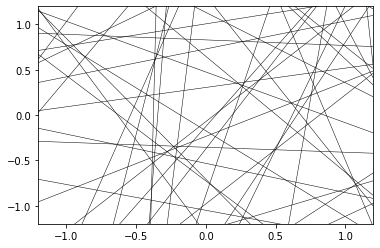

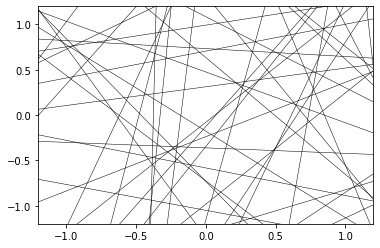

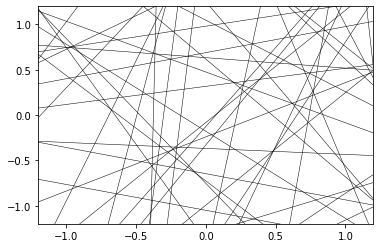

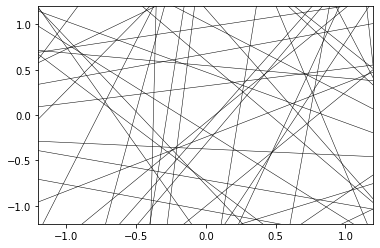

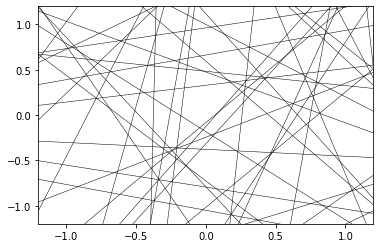

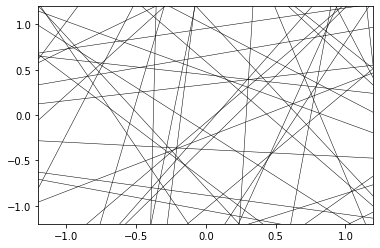

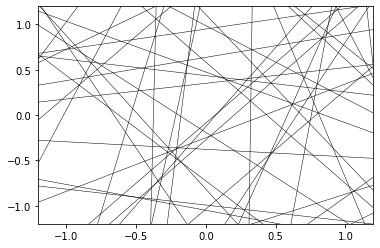

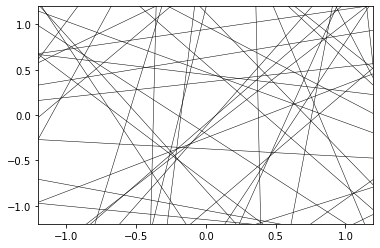

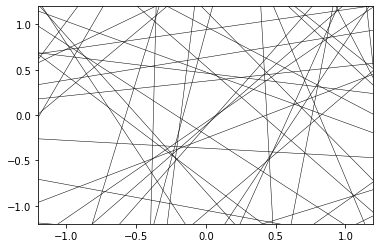

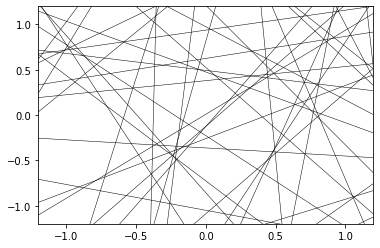

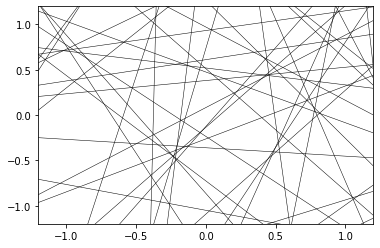

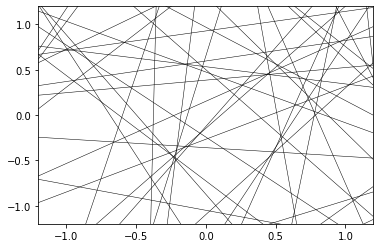

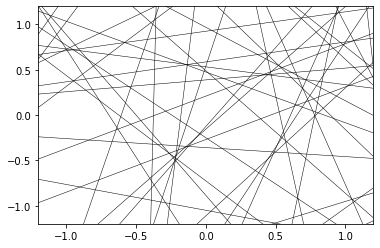

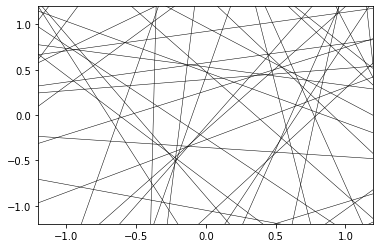

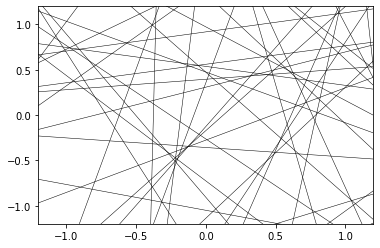

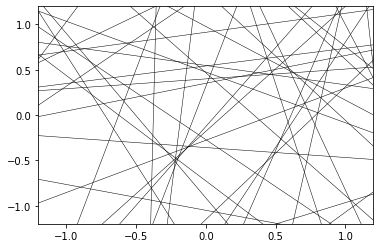

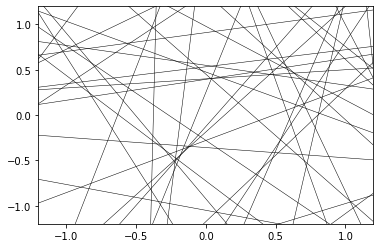

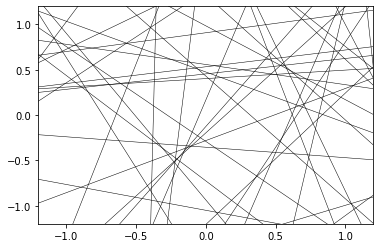

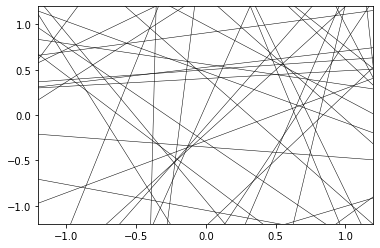

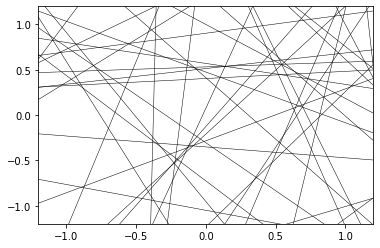

In [ ]:
!rm ./img -r
!mkdir ./img

model = gen_model()
epochs = 30
model.fit(
    X_train, 
    train_labels, 
    epochs=epochs, 
    batch_size=40, 
    callbacks=[PolytopeVisualizationCallback()]
)

In [ ]:
import imageio
import os

frames = [] 

for epoch in range(0, epochs):
    image = imageio.v2.imread(f'./img/img_{epoch}.png')
    frames.append(image)

imageio.mimsave('./out.gif', # output gif
                frames,          # array of input frames
                fps = 2)         # optional: frames per second

$$
a^i_j = max(\begin{bmatrix} w^{i-1}_{1,j} & . . . & w^{i-1}_{len(a^{i-1}),j}\end{bmatrix}
            \begin{bmatrix} a^{i-1}_1\\ ... \\ a^{i-1}_{len(a^{i-1})}\end{bmatrix} + b^i_j, 0)
$$

In [ ]:
x_bounds = X[:, 0]
x_bounds = [x_bounds.min(), x_bounds.max()]
y_bounds = X[:, 1]
y_bounds = [y_bounds.min(), y_bounds.max()]
x_bounds, y_bounds

([1.0, 6.9], [0.1, 2.5])

iris sepals

free dimensions could be outputs just as much as outputs

Two problems:

1) cutting a slice through high dimensional space

2) handling convolutional layers -- how do those translate to polytopes?

Where to take this next:

- [ ] a "suite" of polytope interpretation tools, consisting of:
* given multiple class examples, calculate the Euclidean distance between their spline codes, drawn from their the class example's activation vector
  * would require an ability to map from the activation vector to the spline code: "To calculate the polytope boundary density between two points, we simply divide the Hamming distance in between their spline codes by the Euclidean distance between them. The polytope densities are normalized by dividing by the average polytope density between all pairs of vectors (both intra and inter class)."
* as